### PINNslope: slope estimation and seismic interpolation - Field data
#### Author: Francesco Brandolin

This notebook presents an example of PINNslope for field data interpolation.


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import time
#import m8r
from scipy import signal, ndimage
from itertools import cycle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from pinnslope.Arch_Adaptive import Network
from pinnslope.ArchPE import NetworkPE
from pinnslope.utils import *

# set device to use CPU/GPU:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('What device are we using:', device)
dtype = torch.cuda.FloatTensor

set_seed(42)
g = torch.Generator()
g.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
What device are we using: cuda:0


### Data preparation and initial settings:
By choosing the initial settings listed below, the notebook has the possibility to run both PINNSlope and PWDPINN framework, performing two types of interpolation, as well as loading am already trained PINN to test the performance on different shot gathers.

- crop = True : crops the loaded shot gather

- beyond_aliasing=True : offers the possibility to regularly subsample the data to obtain an aliased shot gather, or to create a large gap of traces in the shot gather.

- load_slope=True :  loads the pre-computed slope (the slope is pre-compute through Madagascar software). In this case the notebook will run the PWDPINN approach instead of the PINNslope framework. It turns off automatically the slope network and uses the pre-computed slope to perform the interpolation. 

- use_pre_trained=True :  it loads pre-trained weights to both slope and wavefield network. With this you can test the performance of the network on different shot-gathers from the one that PINNslope has been trained on (see: "Performance evaluation" section in the article).

Data shape: (119, 1500)
 Beyond aliasing interpolation
Cropped Data shape: (100, 650)
Rop (13000, 65000)
data_obs shape (650, 20)
data_mask shape (650, 100)


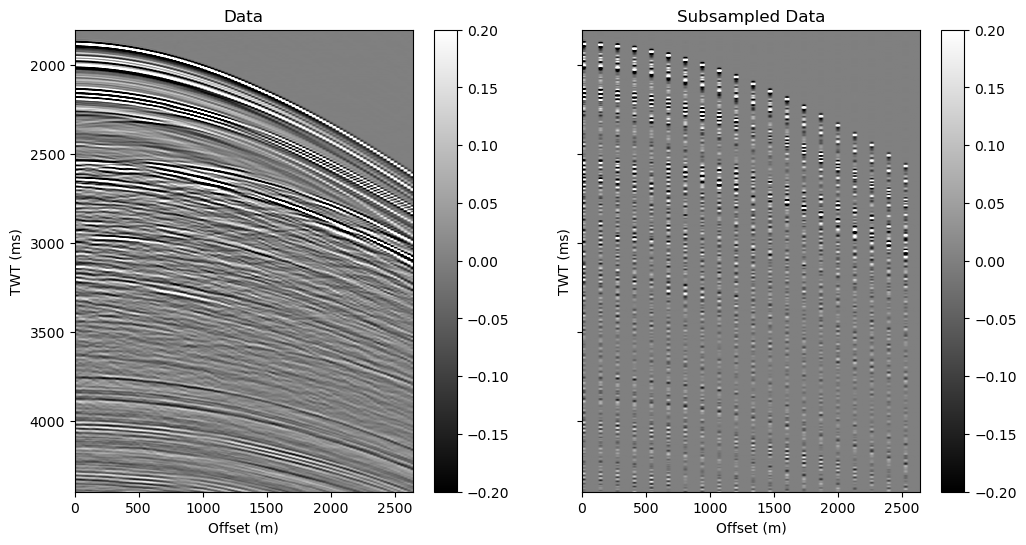

In [4]:
#Loading data:
path = "../data/real_data/GOMgain.npy"
dataset = np.load(path); data = dataset.T; print('Data shape:',data.shape)


# if True creates aliasing in the data, otherwise creates a Large gap to interpolate
beyond_aliasing=True 

if beyond_aliasing==True: 
    # Choose subsampling factor:
    nsub = 5
    print(' Beyond aliasing interpolation')
else:
    # Choose gap size:
    gap_range=[40, 55]
    print('Large gap interpolation')

# crop the shot-gather for fast tests:
crop = True

# Load the PWD estimated slope for PWDPINN approach:
# (!! WARNING: The slope is computed on a low-frequency version of the field data, obtained by a data subsampled by a factor 5 !! 
#  !! Not use the slope with different subsampling factor !!)
load_slope = False

# if True loads a model with pre-trained weights (both for Data-Network and Slope-Network)
use_pre_trained = False



if crop==True:
    
    # Defining crop params:    
    x_start=0; x_end=100; t_start=450; t_end=1100
    data =data[ x_start:x_end, t_start:t_end ]
    print('Cropped Data shape:',data.shape)

    ox, dx, nx = x_start, 26.7, x_end;  ot, dt, nt = t_start, 0.004, t_end
    dim_x = int(nx-ox); dim_t = int(nt-ot)
    x = (np.arange(dim_x)+ ox)* dx
    x = np.reshape(x, (dim_x, 1) )
    t = ((np.arange(dim_t)+ ot) * dt)*1e3
    t = np.reshape(t, (dim_t, 1) )
    

else:
        # Defining full shot-gather params:
        ox, dx, nx = 0, 26.7, 119;  ot, dt, nt = 0, 0.004, 1500
        dim_x = int(nx-ox); dim_t = int(nt-ot) 
        x = (np.arange(dim_x)+ ox)* dx
        x = np.reshape(x, (dim_x, 1) )
        t = ((np.arange(dim_t)+ ot) * dt)*1e3
        t = np.reshape(t, (dim_t, 1) )



# Create restriction operator:
traces_index = np.arange( dim_x ); 

if beyond_aliasing==True: traces_index_sub = traces_index[::nsub]  
else: traces_index_sub = np.concatenate( (traces_index[:gap_range[0]], traces_index[gap_range[1]:]), axis=0 )

Rop = pylops.Restriction( [dim_x, dim_t] , iava=traces_index_sub, axis=0, dtype="float64" ); print('Rop',Rop.shape)

# Apply restriction operator:
data_obs = Rop * (data).ravel()
data_obs = data_obs.reshape(traces_index_sub.shape[0], dim_t)
data_obs = data_obs.T; print('data_obs shape',data_obs.shape)

# mask:
datamask = Rop.mask(data.ravel())
data_mask = datamask.data.T; print('data_mask shape',data_mask.shape)


# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

CMP = axs[0].imshow(data.T, cmap='gray', vmin=-0.2, vmax=0.2, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask.data.T, cmap='gray', vmin=-0.2, vmax=0.2, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('Subsampled Data')
fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')
plt.show()

if load_slope == True:
    slope = np.load('../data/real_data/PWDGOMdata6_5Hz.npy')
    slope = (dim_x/dim_t)*slope.T
    print('slope shape:',slope.shape)
    if crop == True:
        slope = slope[ t_start:t_end , x_start:x_end]; print('cropped slope shape:',slope.shape)

    slope_resh = np.reshape(slope, (slope.shape[0]*slope.shape[1],1))
    print('slope_resh shape', slope_resh.shape)

    plt.figure(figsize=(5,6))
    plt.imshow(slope, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
    plt.axis('tight')
    plt.title('Slope computed with PWD algorithm')
    plt.colorbar()
    plt.show()

### Creating and processing the computational grid

- In this cell the computational grid is created. Then the grid points associated with the position of training traces (right fig. above) are extracted, these are the points passed in the data term of the loss.
  
- Also, the training traces are reshaped and stacked one below the other to be easily pass to the data-term term during the network training.

full_grid size (65000, 2)
traces_training_grid size: (13000, 2)
ground_truth_traces size: (13000, 1)


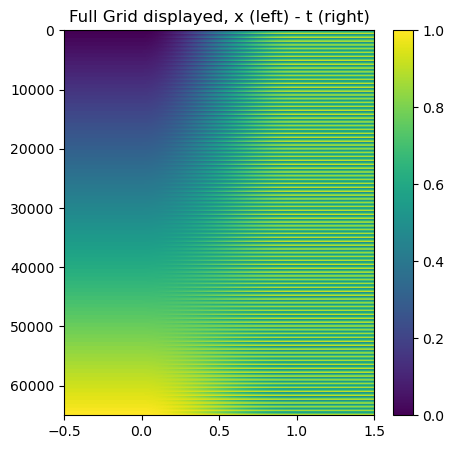

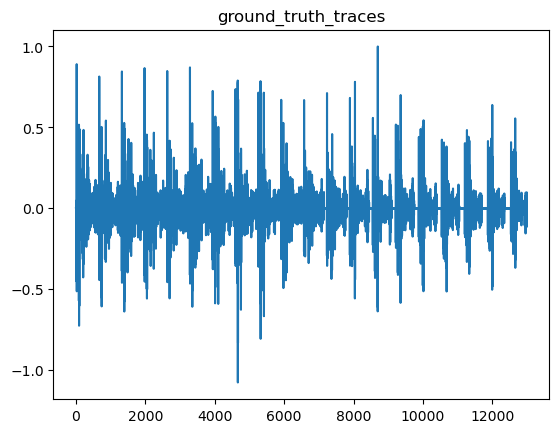

In [5]:
# Creating computational grid:
grx, grt, grX, grT, full_grid = grid(ox, dx, nx, ot, dt, nt, normalization=True)
print('full_grid size', full_grid.shape )

# Creating training traces grid-points from full grid:
traces_training_grid = grid_subsampling(grX, grT, Rop, traces_index_sub.shape[0])
print('traces_training_grid size:', traces_training_grid.shape)

# Reshaping subsampled data to trainig traces:
ground_truth_traces = training_traces(data_obs)
print('ground_truth_traces size:', ground_truth_traces.shape)

plt.figure(figsize=(5,5))
plt.imshow(full_grid)
plt.title('Full Grid displayed, x (left) - t (right)')
plt.axis('tight')
plt.colorbar()
plt.show()

plt.plot(ground_truth_traces)
plt.title('ground_truth_traces')
plt.show()


### Network initialization

In [6]:
# New data network:
lay = 'linear' ; act = 'Tanh'; PosEnc=[8,32,2] # PosEnc=[x_dim, t_dim, scale]
model = NetworkPE((PosEnc[0]*2+PosEnc[1]*2), 1, [512,512,512,512], act=act, lay=lay, PosEnc=PosEnc, device=device).to(device)

# Loads the weights of a prevuoisly trained model
if use_pre_trained==True:
    model.load_state_dict(torch.load('../data/pre_trained_models/GOM_512x4_tanh.pt')); model.to(device)
    print('Pre-trained weights have been loaded !')


### Hyperparameteres settings and Dataloader

- Sets the hyperparameters for training.

- Creates two TensorDatasets one with the full grid and one with the training traces grid points and the training traces. 

In [7]:
# Choose the learning rate:
lr = 1e-3

# Choose number of epochs:
epochs = 2000

# Grid batches:
batch_grid_slope = 1000
n_grid_slope_batches = int((full_grid.shape[0])/batch_grid_slope)
print(' - Number of Grid/Slope batches:', n_grid_slope_batches)

# Training traces batches:
n_train_traces_batches = 2
batch_traces_size = int((ground_truth_traces.shape[0])/n_train_traces_batches)
print(' - Traces batch size:',batch_traces_size)

# Choose Data term in Loss function:
Loss1 = nn.L1Loss(reduction='mean')

# Define the weight for the data term (MSE Loss):
lamda = 100

# Choose the optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)



# Decides if we are using a pre-computed slope or train a new Slope Network from scratch:
if load_slope == True:
    grid_slope = np.concatenate((full_grid, slope_resh), axis=1)
    print('Using a pre-computed slope')
else:
    # Create a new random initialized Slope Network:    
    lay2 = 'linear' ; act2 = 'Tanh'
    modelSlope = Network(2, 1, [2,2], act=act2, lay=lay2).to(device)

    if use_pre_trained==True:
        modelSlope.load_state_dict(torch.load('../data/pre_trained_models/slopeGOM_2x2_tanh.pt'))
        print('Pre-trained weights have been loaded')
    
    optimizer_slope = torch.optim.Adam(modelSlope.parameters(), lr=lr)
    grid_slope=full_grid
    print('Using a network to estimate the slope')



# TensorDataset for PDE loss term (Full grid-points):
grid_slope = torch.from_numpy(grid_slope).type(dtype).to(device)
print('- grid_slope size:',grid_slope.shape)
grid_slope = TensorDataset(grid_slope)

# TensorDataset for dat-term (training traces):
tracesGrid_tracesGT = np.concatenate(( traces_training_grid, ground_truth_traces ), axis=1)
tracesGrid_tracesGT = torch.from_numpy(tracesGrid_tracesGT).type(dtype).to(device)
print('- tracesGrid_tracesGT size:', tracesGrid_tracesGT.shape)
tracesGrid_tracesGT = TensorDataset(tracesGrid_tracesGT)

 - Number of Grid/Slope batches: 65
 - Traces batch size: 6500
Using a network to estimate the slope
- grid_slope size: torch.Size([65000, 2])
- tracesGrid_tracesGT size: torch.Size([13000, 3])


### Training function

Function that trains PINNslope (or PWDPINN).

In [8]:
loss_values = []; loss_data_values = []; loss_phy_values = []; loss_no_ada_values=[]
    
        
def closure():
    
    model.train()
    optimizer.zero_grad()
    input_grid_points = a[0][:,:2]; traces_grid_points = b[0][:,:2]; gt_traces = (b[0][:,2]).view(-1,1);
    input = (torch.cat((input_grid_points, traces_grid_points), axis=0)).requires_grad_(True)
    u = model(input)
    
    # Automatic Differentiation:
    gradient = torch.autograd.grad( u, input, torch.ones_like(u), create_graph=True)[0]
    dx = gradient[: (input.shape[0] - (batch_traces_size)), 0]
    dt = gradient[: (input.shape[0] - (batch_traces_size)), 1]

    if load_slope==True:
        slope_values = a[0][:,2]
        # Physical Loss term with pre-computed slope:
        loss_phy = torch.mean((dx + slope_values*dt)**2)
    else:
        modelSlope.train()
        optimizer_slope.zero_grad()
        sigma = modelSlope(input_grid_points)
        # Physical Loss term with network estimated slope:
        loss_phy = torch.mean((dx + sigma[:,0]*dt)**2)

    # MSE Loss term:
    loss_data = Loss1(u[(input.shape[0] - (batch_traces_size)):], gt_traces)
    
    # Total Loss function:
    loss = lamda*loss_data + loss_phy 

    # Storing losses values:
    loss_phy_values.append(loss_phy.item())
    loss_data_values.append(loss_data.item())
    loss_values.append(loss.item()) 
    
    loss.backward(retain_graph=True)

    return   

### Training loop

The training loop wraps the training function (closure()) and runs the network for the specified number of epochs.

In [9]:
start = time.time()

# Run the network:
for i in range(epochs):
    
    if i % 100==0:
        print('epoch:',i)
    
    grid_slope_loader = DataLoader(grid_slope, batch_size=batch_grid_slope, shuffle=True, drop_last=True, generator=g)
    tracesGrid_tracesGT_loader = DataLoader(tracesGrid_tracesGT, batch_size=batch_traces_size, shuffle=True, drop_last=True, generator=g)
  
    for a, b in zip(grid_slope_loader, cycle(tracesGrid_tracesGT_loader)):
        
        closure()
        
        optimizer.step()
        
        if load_slope==False:
            optimizer_slope.step()


end = time.time()
print('Total Runtime is: %f [minutes] ' %((end-start)/60))

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
epoch: 1000
epoch: 1100
epoch: 1200
epoch: 1300
epoch: 1400
epoch: 1500
epoch: 1600
epoch: 1700
epoch: 1800
epoch: 1900
Total Runtime is: 65.783760 [minutes] 


In [10]:
## Model evaluation and plotting:
model.eval()
u_out = model( torch.from_numpy(full_grid).type(dtype).requires_grad_(True) )
u_npy = u_out.cpu().detach().cpu().numpy()
u_npy = np.reshape(u_npy, (dim_x, dim_t))
u_npy = u_npy.T

## Slope Model evaluation:
if load_slope==False: 
    modelSlope.eval()
    sigma_out = modelSlope( torch.from_numpy(full_grid).type(dtype).to(device).requires_grad_(True) )
    sigma_npy = sigma_out.cpu().detach().cpu().numpy()
    sigma_npy = np.reshape(sigma_npy, (dim_x,dim_t))
    sigma_npy = sigma_npy.T

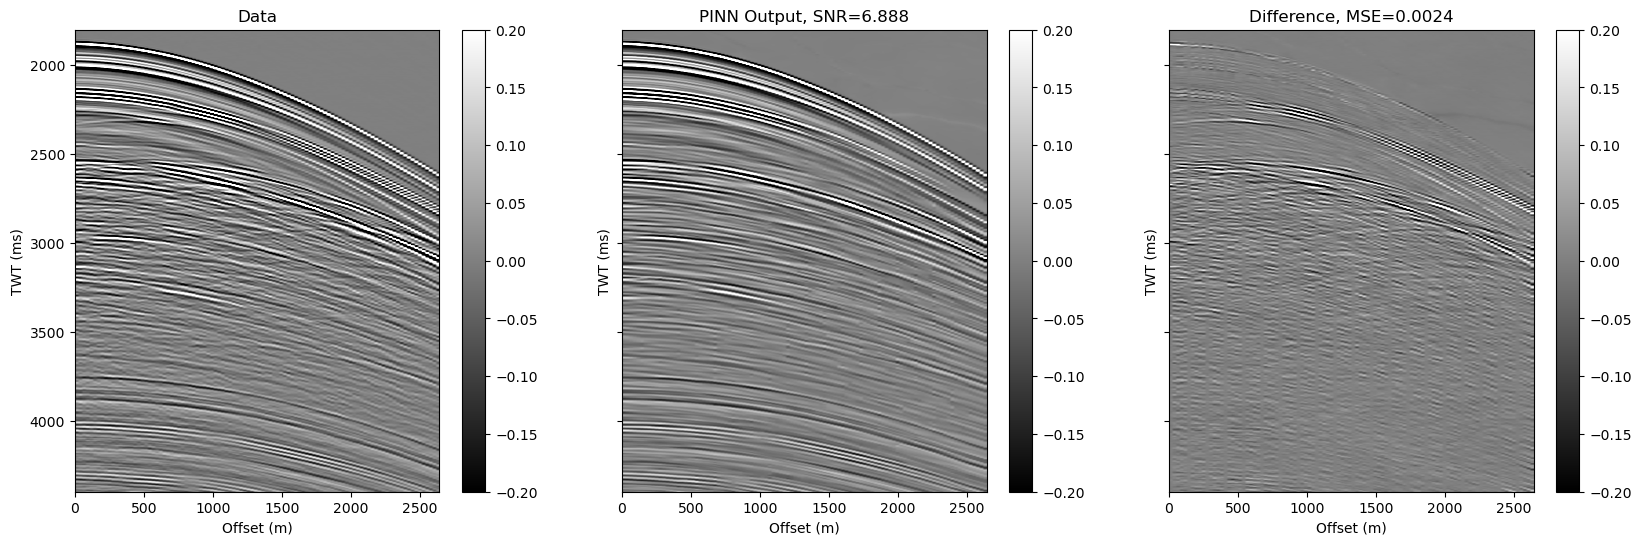

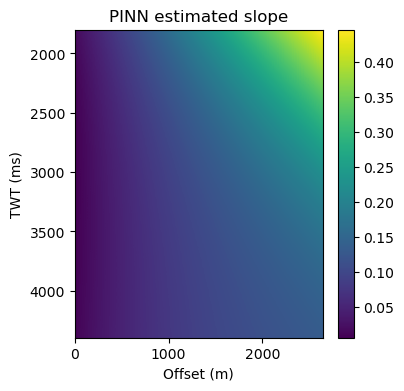

In [11]:
# Results:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

vmin=-0.2; vmax=0.2

CMP=axs[0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

OUT=axs[1].imshow(u_npy, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('PINN Output, SNR={}'.format( round(snr(data.T,u_npy),3) ) )
fig.colorbar(OUT, ax=axs[1])
axs[1].axis('tight')

DIFF=axs[2].imshow((data.T-u_npy), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (ms)')
axs[2].set_title('Difference, MSE={}'.format( round((mse(data.T, u_npy)),4) ) )
fig.colorbar(DIFF, ax=axs[2])
axs[2].axis('tight')
plt.show()


if load_slope == False:

    plt.figure(figsize=(4,4))
    plt.imshow(sigma_npy,  extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
    plt.axis('tight')
    plt.title('PINN estimated slope')
    plt.xlabel('Offset (m)')
    plt.ylabel('TWT (ms)')
    plt.colorbar()
    plt.show()

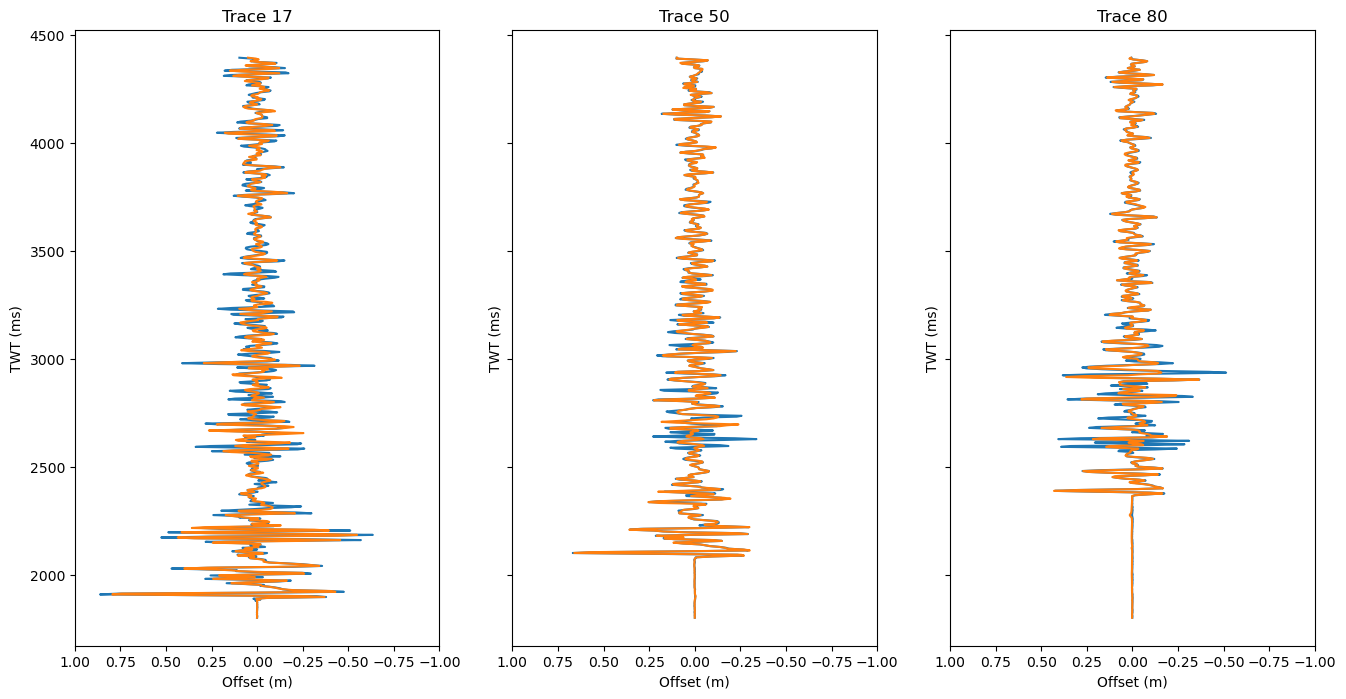

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1, 1]})
tr1=17; tr2=50; tr3=80
axs[0].plot(data.T[:,tr1], t)
axs[0].plot(u_npy[:,tr1], t)
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Trace %.f' % tr1)
axs[0].axis('tight')
axs[0].set_xlim(1,-1)

axs[1].plot(data.T[:,tr2], t)
axs[1].plot(u_npy[:,tr2], t)
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('Trace %.f' % tr2)
axs[1].axis('tight')
axs[1].set_xlim(1,-1)

axs[2].plot(data.T[:,tr3], t)
axs[2].plot(u_npy[:,tr3], t)
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (ms)')
axs[2].set_title('Trace %.f' % tr3)
axs[2].axis('tight')
axs[2].set_xlim(1,-1)
plt.show()

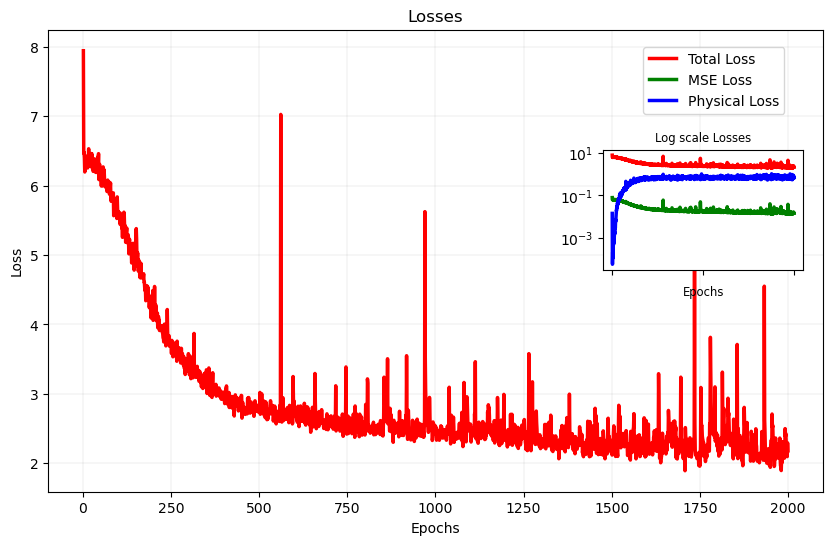

In [13]:
# Plotting the Loss:  
lossphy = [loss_phy_values[ep*n_grid_slope_batches] for ep in range(epochs)]
lossdata = [loss_data_values[ep*n_grid_slope_batches] for ep in range(epochs)]
losstot = [loss_values[ep*n_grid_slope_batches] for ep in range(epochs)]

fig, axs = plt.subplots(figsize=(10,6))

epochs_axis = np.linspace(1, epochs, epochs)

axs.plot(epochs_axis, losstot, '-', color='red', linewidth=2.5)
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.set_title('Losses')
axs.grid(color='grey', linestyle='-', linewidth=0.1)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.68, 0.48, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(epochs_axis, losstot, '-', color='red', linewidth=2.5)
ax2.plot(epochs_axis, lossdata, '-', color='green', linewidth=2.5)
ax2.plot(epochs_axis, lossphy, '-', color='blue', linewidth=2.5)
ax2.set_yticklabels([]); ax2.set_xticklabels([])
ax2.set_xlabel('Epochs', fontsize='small')
ax2.set_yscale('log')
ax2.set_title('Log scale Losses', fontsize='small')
ax2.legend(['Total Loss ', 'MSE Loss', 'Physical Loss'], loc = ( 0.2, 1.3))
plt.show()

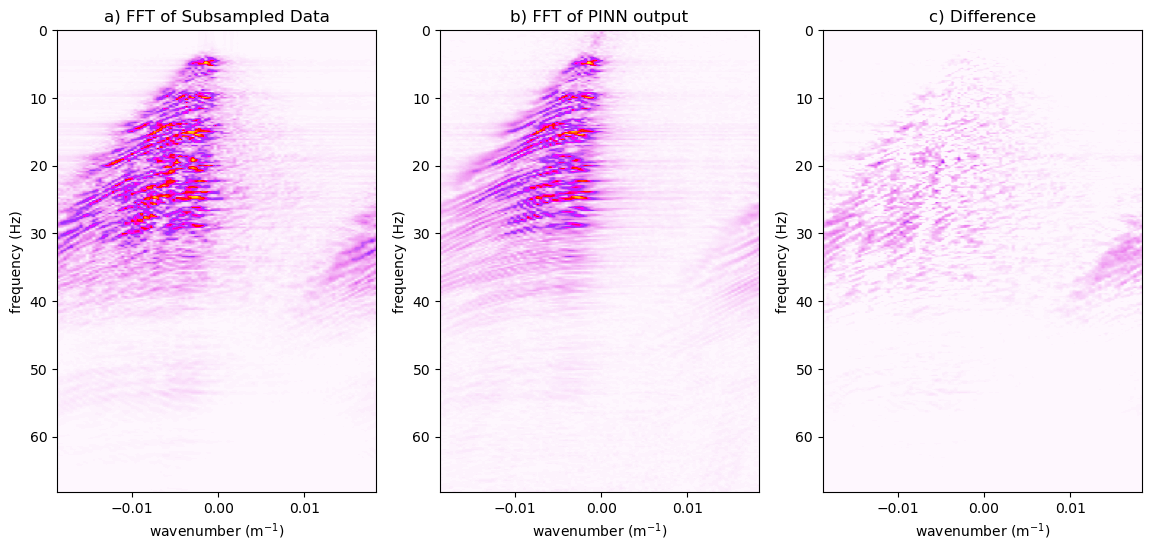

In [14]:
f, kx = np.fft.fftfreq(nt, dt), np.fft.fftfreq(nx, dx)

FFTorigin = np.fft.fft2(data)
FFTorigin = FFTorigin.T
FFToutPINN = np.fft.fft2(u_npy)

# Plotting data, mask, data with mask applied:
fig, axs = plt.subplots(1, 3,  figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

limit_plot = 300

vmax = 500

axs[0].imshow(np.fft.fftshift(np.abs(FFTorigin[:limit_plot]), axes=1), cmap = 'gist_ncar_r', vmin=np.min(np.abs(FFTorigin[:limit_plot])), vmax=vmax ,
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1], f[limit_plot], f[0]))
axs[0].set_ylabel('frequency (Hz)')
axs[0].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)')
axs[0].set_title('a) FFT of Subsampled Data')
axs[0].axis('tight')

axs[1].imshow(np.fft.fftshift(np.abs(FFToutPINN[:limit_plot]), axes=1), cmap = 'gist_ncar_r', vmin=np.min(np.abs(FFTorigin[:limit_plot])), vmax=vmax ,
              extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[1].set_ylabel('frequency (Hz)')
axs[1].set_title('b) FFT of PINN output')
axs[1].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)')
axs[1].axis('tight')

axs[2].imshow(np.fft.fftshift(np.abs(FFTorigin[:limit_plot]) - np.abs(FFToutPINN[:limit_plot]), axes=1), cmap = 'gist_ncar_r', vmin=np.min(np.abs(FFTorigin[:limit_plot])), vmax=vmax ,extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[2].set_ylabel('frequency (Hz)')
axs[2].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)')
axs[2].set_title('c) Difference')
axs[2].axis('tight')
plt.show()

torch.save(model.state_dict(), '../data/pre_trained_models/GOM_512x4_tanh.pt')
torch.save(modelSlope.state_dict(), '../data/pre_trained_models/slopeGOM_2x2_tanh.pt')

np.save('../data/Results/RealResults/csg_recon/csg150_recon.npy', u_npy)
np.save('../data/Results/RealResults/csg_recon/losscsg150_recon.npy', losstot)


np.save('../data/Results/RealResults/slopePINNout.npy', sigma_npy)

np.save('../data/Results/RealResults/DoublePINNout.npy', u_npy)

if load_slope == False:
    np.save('../data/Results/RealResults/lossesDoublePINN/lossphy.npy', lossphy)
    np.save('../data/Results/RealResults/lossesDoublePINN/lossdata,py', lossdata)
    np.save('../data/Results/RealResults/lossesDoublePINN/losstot.npy', losstot)

else:
    np.save('../data/Results/RealResults/lossesPWDPINN/lossphy.npy', lossphy)
    np.save('../data/Results/RealResults/lossesPWDPINN/lossdata,py', lossdata)
    np.save('../PWDPINNs/data/Results/RealResults/lossesPWDPINN/losstot.npy', losstot)